In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from datetime import date
import datetime
from bs4 import BeautifulSoup
import requests
import pandas as pd
from datetime import date
import datetime
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from  time import sleep

In [2]:
from config import *

In [3]:
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials

In [8]:
def getting_df(url):
    response = requests.get(url)
    response.status_code # 200 status code means OK!
    soup = BeautifulSoup(response.content, "html.parser")
    artist = []
    song = []

    for tag in soup.select(".chart-element__information__artist"):
        artist.append(tag.get_text())

    for tag in soup.select(".chart-element__information__song"):
        song.append(tag.get_text())

    d = {'artist': artist, 'song': song}
    df = pd.DataFrame(d,columns = ['artist','song'])
    df.drop_duplicates(inplace=True)
    df['creation_ddbb'] = date.today()
    return df

'def getting_df(url):\n    response = requests.get(url)\n    response.status_code # 200 status code means OK!\n    soup = BeautifulSoup(response.content, "html.parser")\n    artist = []\n    song = []\n\n    for tag in soup.select(".chart-element__information__artist"):\n        artist.append(tag.get_text())\n\n    for tag in soup.select(".chart-element__information__song"):\n        song.append(tag.get_text())\n\n    d = {\'artist\': artist, \'song\': song}\n    df = pd.DataFrame(d,columns = [\'artist\',\'song\'])\n    df.drop_duplicates(inplace=True)\n    df[\'creation_ddbb\'] = date.today()\n    return df\n'

In [10]:
def updating_df(url,df):
    response = requests.get(url)
    response.status_code # 200 status code means OK!
    soup = BeautifulSoup(response.content, "html.parser")
    new_artist = []
    new_song = []
    for tag in soup.select(".chart-element__information__artist"):
        new_artist.append(tag.get_text())
    for tag in soup.select(".chart-element__information__song"):
        new_song.append(tag.get_text().capitalize())
    for s in list(df.song):
        if s not in new_song:
            df.drop(list(df[df.song == s].index))
    for s in new_song:
        if s not in list(df.song):
            new_row = {'artist': new_artist[new_song.index(s)] ,'song': s,'creation_ddbb': date.today()}
            df = df.append(new_row, ignore_index=True)
    df.to_csv('billboard_music_db.csv', index=False)
    return df
# second url to try: https://www.billboard.com/charts/billboard-200


In [11]:
def choose_song(song_customer,final_df):
    if song_customer in list(final_df.song):
        artist_customer = final_df[final_df['song'] == song_customer]['artist'].values[0]
        if len(final_df[final_df.artist == artist_customer]) > 1:
            results_df = final_df[final_df['artist'] == artist_customer]
            results_df = results_df[results_df['song'] != song_customer]
        else:
            results_df = final_df[final_df['song'] != song_customer]
        return results_df[['artist','song']].sample(1)
    else:
        print("This is not a hot song")

In [12]:
def recommendation(url,df=None,song_customer=(input('Choose a song: '))):
    if df is None:
        df = getting_df(url)
    else:
        df = pd.read_csv('billboard_music_db.csv')
        df['creation_ddbb'] = pd.to_datetime(df['creation_ddbb'], format = '%Y/%m/%d')
        if date.today() > df['creation_ddbb'][0]:
            df = updating_df(url,df)
    return choose_song(song_customer,df)

recommendation('https://www.billboard.com/charts/hot-100')

Choose a song: up
This is not a hot song


Lab | API wrappers - Create your collection of songs & audio features

Instructions
To move forward with the project, you need to create a collection of songs with their audio features - as large as possible!

These are the songs that we will cluster. And, later, when the user inputs a song, we will find the cluster to which the song belongs and recommend a song from the same cluster. The more songs you have, the more accurate and diverse recommendations you'll be able to give. Although... you might want to make sure the collected songs are "curated" in a certain way. Try to find playlists of songs that are diverse, but also that meet certain standards.

The process of sending hundreds or thousands of requests can take some time - it's normal if you have to wait a few minutes (or, if you're ambitious, even hours) to get all the data you need.

An idea for collecting as many songs as possible is to start with all the songs of a big, diverse playlist and then go to every artist present in the playlist and grab every song of every album of that artist. The amount of songs you'll be collecting per playlist will grow exponentially!

In [4]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= spotify_client_id,
                                                           client_secret= spotify_client_secret))

In [5]:
def get_playlist_tracks(username, playlist_id):
    '''return songs from playlist'''
    results = sp.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [6]:
# extract song names and artists from playlist
def song_artist(username, playlist_id):
    '''return artist's songs from songs from playlist'''
    song_artist_dict = {}
    playlist_len = len(get_playlist_tracks(username, playlist_id))
    #if playlist_len > 300:
        #playlist_len = 300
    for i in range(playlist_len):
        song_name = get_playlist_tracks(username, playlist_id)[i]['track']['name']
        song_id = get_playlist_tracks(username, playlist_id)[i]['track']['id']
        singer = get_playlist_tracks(username, playlist_id)[i]['track']['artists'][0]['name']
        song_artist_dict[singer] = song_name
        sleep(1)
    return song_artist_dict

In [7]:
def artist_songs(song_artist_dict):
    '''returns a dictionary with the artists and their songs'''
    list_songs_artist = {}
    for artist in song_artist_dict.keys():
        songs = sp.search(q=artist,limit=10)
        test = [] 
        for i in range(10):
            try:
                song = songs["tracks"]["items"][i]['name']
                if song not in list_songs_artist.values():
                    test.append(song)

            except:
                break
        list_songs_artist[artist] = test
    return list_songs_artist

def song_info(list_songs_artist):
    '''returnsa dictionary with songs and its info'''
    list_songs_info = {}
    for song_element in list_songs_artist.values():
        for s in song_element:
            song_choosen = sp.search(q=s,limit=1)
            list_songs_info[s] = sp.audio_features(song_choosen["tracks"]["items"][0]["uri"])[0]
    return list_songs_info


In [126]:
def create_df(info):
    '''create df of the songs and their info'''
    danceability = []
    energy =[]
    key = []
    loudness = []
    mode = []
    speechiness = []
    acousticness = []
    instrumentalness = []
    liveness = []
    valence =[]
    tempo = []
    _type = []
    _id = []
    uri = []
    duration_ms = []
    time_signature = []
    for _song in info.keys():
        features_info = [danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,_type,_id,uri,duration_ms,time_signature]
        features_tags = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo,_type','_id','uri','duration_ms','time_signature']

        for i in range(len(features_info)-1):
            feature = features_info[i]
            tag = features_tags[i]
            try:
                feature.append(info[_song][tag])
            except:
                feature.append(0)
   
    new_dict ={}

    for i in range(len(features_info)-1):
        feature = features_info[i]
        tag = features_tags[i]
        new_dict[tag] = feature
    
    df = pd.DataFrame(new_dict)
    #df.to_csv('db_spotify_project.csv')
    return df

In [9]:
song_artist_dict = song_artist("spotify", "0lNwm5xFEgRx4iDP2DLx3j")
#"4rnleEAOdmFAbRcNCgZMpY" 5000 songs
# possible playlists to test
#"5Rrf7mqN8uus2AaQQQNdc1" 500 top hit songs
#"43Q8AWJBVTzAl1XPWyPKZQ" 500 rare songs
#"4uoPRLaoEtvHXuoTuIM387" small list
#"0BnvDJToAhcWJDaCb2M7pz" small list
#"4QOTdWe1tig5hSsINrCKkW" really small list
#0lNwm5xFEgRx4iDP2DLx3j 1000 songs

In [12]:
list_song_artist =artist_songs(song_artist_dict)

In [13]:
info = song_info(list_song_artist)

In [127]:
df = create_df(info)

In [128]:
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,"tempo,_type",_id,uri,duration_ms,time_signature
0,0.547,0.257,0,-12.358,1,0.0252,0.90700,0.183000,0.0935,0.169,0,0,spotify:track:7pKfPomDEeI4TPT6EOYjn9,187867,4
1,0.321,0.640,2,-10.023,1,0.0324,0.28000,0.000000,0.7180,0.414,0,0,spotify:track:27RYrbL6S02LNVhDWVl38b,214333,3
2,0.574,0.469,2,-11.530,1,0.0403,0.73300,0.000002,0.8560,0.435,0,0,spotify:track:5URfZHMlUWTWxPvvSBWcPk,245693,4
3,0.684,0.210,1,-18.204,0,0.0841,0.53800,0.031000,0.1430,0.681,0,0,spotify:track:4bN43jYf41eIjJZ3UXQpuA,112040,4
4,0.588,0.656,3,-6.373,1,0.0224,0.37800,0.002270,0.0420,0.746,0,0,spotify:track:0GGxVTb0UwDwdaKNjBdCn3,212933,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,0.687,0.793,2,-4.254,1,0.1660,0.06030,0.000000,0.5820,0.751,0,0,spotify:track:5sNESr6pQfIhL3krM8CtZn,205733,4
5208,0.580,0.702,4,-5.565,1,0.0337,0.04660,0.000003,0.5360,0.299,0,0,spotify:track:57BrRMwf9LrcmuOsyGilwr,208960,4
5209,0.585,0.972,9,-4.450,0,0.0534,0.01430,0.000000,0.0707,0.585,0,0,spotify:track:7oVEtyuv9NBmnytsCIsY5I,230253,4
5210,0.524,0.939,9,-3.994,1,0.1130,0.00022,0.000000,0.6230,0.661,0,0,spotify:track:1Vej0qeQ3ioKwpI6FUbRv1,184867,4


In [129]:
df = df.select_dtypes(np.number)
X_prep = StandardScaler().fit_transform(df)
pd.DataFrame(X_prep, columns=df.columns).head()
kmeans = KMeans(n_clusters=30, random_state=1234)
kmeans.fit(X_prep)
clusters = kmeans.predict(X_prep)

X_df = pd.DataFrame(df)
X_df["cluster"] = clusters
X_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,"tempo,_type",_id,duration_ms,time_signature,cluster
0,0.547,0.257,0,-12.358,1,0.0252,0.90700,0.183000,0.0935,0.169,0,0,187867,4,9
1,0.321,0.640,2,-10.023,1,0.0324,0.28000,0.000000,0.7180,0.414,0,0,214333,3,19
2,0.574,0.469,2,-11.530,1,0.0403,0.73300,0.000002,0.8560,0.435,0,0,245693,4,19
3,0.684,0.210,1,-18.204,0,0.0841,0.53800,0.031000,0.1430,0.681,0,0,112040,4,23
4,0.588,0.656,3,-6.373,1,0.0224,0.37800,0.002270,0.0420,0.746,0,0,212933,4,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,0.687,0.793,2,-4.254,1,0.1660,0.06030,0.000000,0.5820,0.751,0,0,205733,4,8
5208,0.580,0.702,4,-5.565,1,0.0337,0.04660,0.000003,0.5360,0.299,0,0,208960,4,8
5209,0.585,0.972,9,-4.450,0,0.0534,0.01430,0.000000,0.0707,0.585,0,0,230253,4,14
5210,0.524,0.939,9,-3.994,1,0.1130,0.00022,0.000000,0.6230,0.661,0,0,184867,4,8


In [130]:
kmeans = KMeans(n_clusters=5,
                init="random",
                n_init=3,  # try with 1, 4, 8, 20, 30, 100...
                max_iter=2,
                tol=0,
                algorithm="full",
                random_state=1234)
kmeans.fit(X_prep)
print(kmeans.inertia_)

44288.87728748102


Text(0.5, 1.0, 'Elbow Method showing the optimal k')

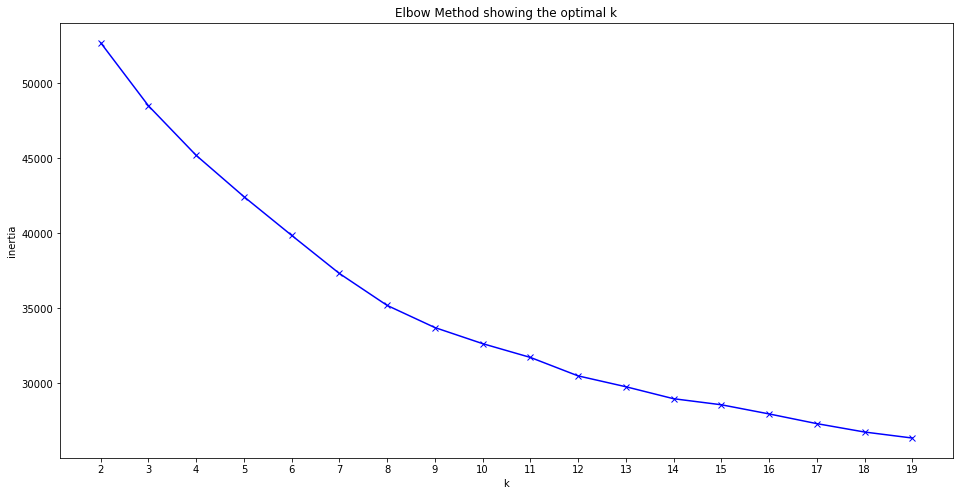

In [131]:
K = range(2, 20)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

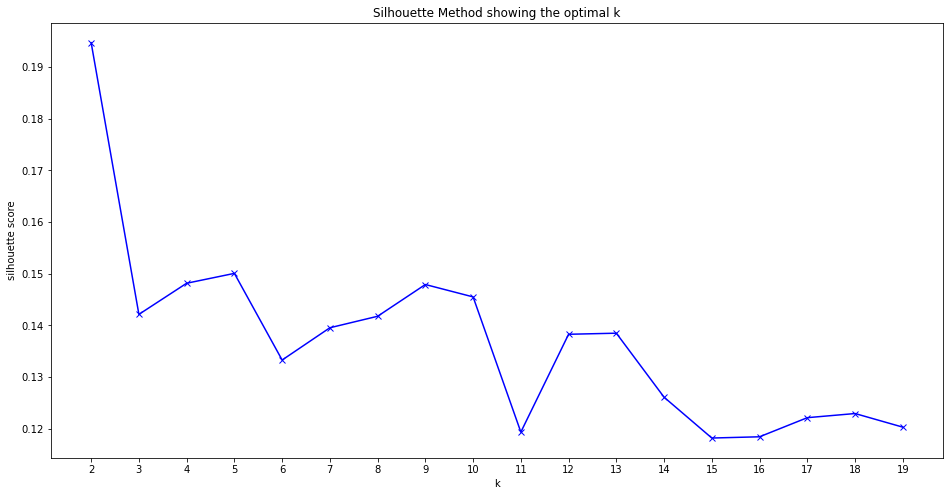

In [132]:
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')